# Исследование сервиса аренды самокатов GoFast
Заказчик этого исследования — сервиса аренды самокатов GoFast. 

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться без подписки и с подпиской Ultra

**Цель исследования** - проанализировать данные о использовании сервиса пользователями без подписки и с подпиской Ultra

**Ход исследования**
Данные получим из трех датафреймов. Перед тем, как проводить анализ, проведем их предобработку, проверим их на предмет наличия дубликатов и пропусков.

Далее опишем и визуализируем общую информацию о пользователях и поездках, после чего объеденим данные в один датафрейм. 

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными и посчитаем помесячную выручку, которую принёс каждый пользователь.

Проверим гипотезы, на основании которых будут проводиться акции для увеличения количетсва пользователей с подпиской.

Таким образом, исследование пройдет в 5 этапов:

- обзор данных
- предобработка данных
- визуализация общей информации о пользователей
- подсчет помесячной выручки
- проверка гипотез

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
#считываем csv-файлы
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
#выводим информацию и первые 5 строк датафрейма users_go
users_go.info()
users_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


**Всего в датафрейме 1565 записей, 5 столбцов**

In [4]:
#выводим информацию и первые 5 строк датафрейма rides_go
rides_go.info()
rides_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


**Всего в датафрейме 18068 записей, 4 столбца**

In [5]:
#выводим информацию и первые 5 строк датафрейма subscriptions_go
subscriptions_go.info()
subscriptions_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Всего в датафрейме 2 записи, 4 столбца**

#### Шаг 2. Предобработка данных

In [6]:
#проверим датафрейм users_go на пропуски
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [7]:
#проверим датафрейм users_go на пропуски
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [8]:
#проверим датафрейм users_go на пропуски
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Пропусков в исходных датафреймах нет**

In [9]:
#приводим столбец date из датафрейма rides_go к типу даты.
rides_go['date'] = pd.to_datetime(rides_go['date'], format = '%Y-%m-%d')

In [10]:
#добавим новый столбец с номером месяца
rides_go['month'] = rides_go['date'].dt.month
rides_go['month'].head()

0    1
1    1
2    4
3    8
4    8
Name: month, dtype: int64

In [11]:
print('Записи с', rides_go['date'].min(), 'по', rides_go['date'].max())

Записи с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


In [12]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [13]:
#проверим датафрейм users_go на дубликаты
users_go.duplicated().sum()

31

In [14]:
#удалим дубликаты в датафрейме users_go
users_go.drop_duplicates(inplace=True)

In [15]:
users_go.duplicated().sum()

0

In [16]:
#проверим датафрейм rides_go на дубликаты
rides_go.duplicated().sum()

0

In [17]:
#проверим датафрейм subscriptions_go на дубликаты
subscriptions_go.duplicated().sum()

0

**В ходе предобработки данных проверили датафреймы на пропуски и удалили дубликаты, а также привели столбец date к типу даты**

#### Шаг 3. Исследовательский анализ данных

In [18]:
#изучим частоту встречаемости городов
users_per_city = users_go['city'].value_counts()
users_per_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

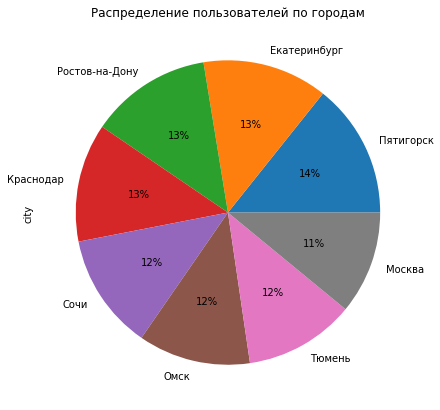

In [19]:
users_go['city'].value_counts().plot(
    kind = 'pie', 
    y = users_per_city,
    autopct = '%1.0f%%',
    figsize=(7,7), 
    title = 'Распределение пользователей по городам');

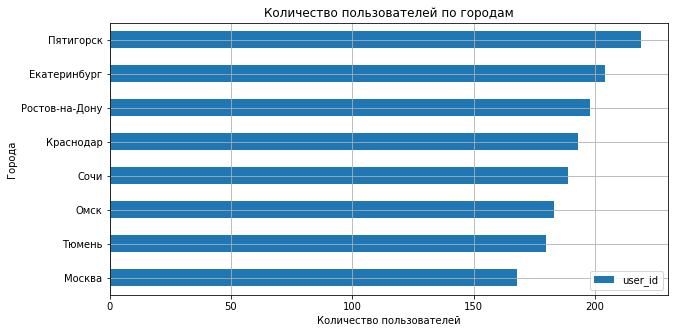

Количество пользователей по городам 


,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [20]:
(
    users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True)
    .plot(kind='barh', grid=True, figsize=(10, 5))
)
plt.title('Количество пользователей по городам')
plt.ylabel('Города')
plt.xlabel('Количество пользователей')

plt.show()
print('Количество пользователей по городам ') 
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

**Визуализация показывает, что распределение по городам примерно одинаковое. Самое большое количество пользователей в Пятигорске, меньше всего пользователей в Москве.**

In [21]:
#изучим соотношение пользователей с подпиской и без
subscriptions_ratio = users_go['subscription_type'].value_counts()
subscriptions_ratio

free     835
ultra    699
Name: subscription_type, dtype: int64

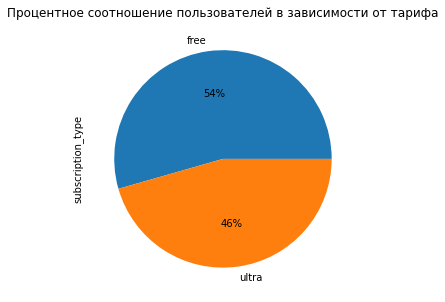

In [22]:
users_go['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = subscriptions_ratio, 
    autopct = '%1.0f%%', 
    figsize=(5,5),
    title = 'Процентное соотношение пользователей в зависимости от тарифа');

**Количество пользователей без подписки чуть больше, чем с подпиской Ultra - приблизительно на 8%**

In [23]:
#изучим возраст пользователей
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

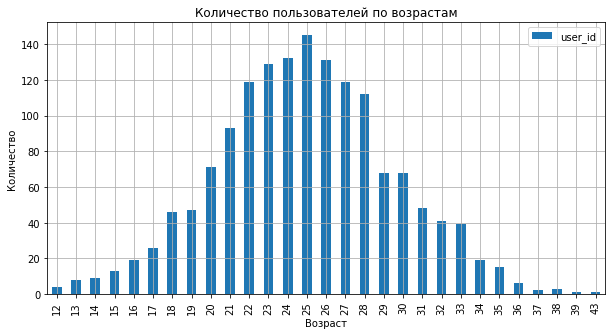

In [24]:
(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True)
    .plot(kind='bar' , grid=True, figsize=(10, 5))
)
plt.title('Количество пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

**Возраст пользователей описывается нормальным распредлением с медианой в 25 лет**

In [25]:
#изучим расстояние, которое пользователь преодолел за одну поездку
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

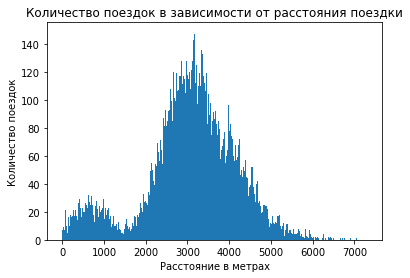

In [26]:
plt.hist(rides_go['distance'], bins=500, range=(0,7300))
plt.title('Количество поездок в зависимости от расстояния поездки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

**Медиана одной поездки составляет 3133 метра, немногим больше среднего значения в 3070 метров за одну поездку**

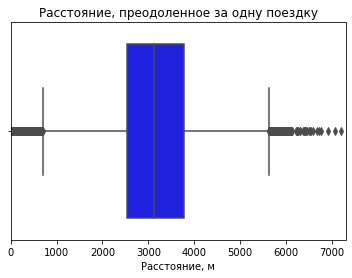

In [27]:
sns.boxplot(x=rides_go['distance'], color='blue')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
_ = plt.xlim(0, 7300)

In [28]:
#изучим продолжительность поездок
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

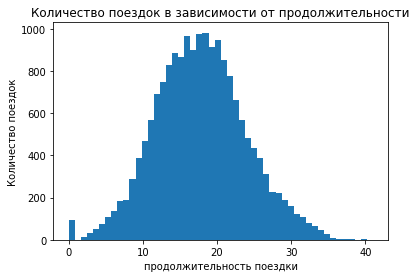

In [29]:
plt.hist(rides_go['duration'], bins=50, range=(0,41))
plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

**Медиана одной поездки по времени составляет чуть больше 17 минут и практически совпадает со средним значением**

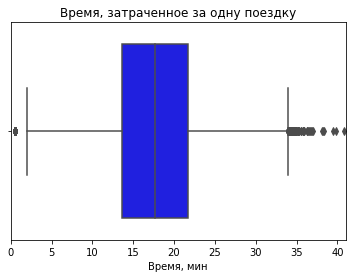

In [30]:
sns.boxplot(x=rides_go['duration'], color='blue')
plt.title('Время, затраченное за одну поездку')
plt.xlabel('Время, мин')
_ = plt.xlim(0, 41)

**Промежуточные выводы**
* преимущественно сервисом пользуются южные города, такие как Пятигорск, Ростов на Дону, Красноадр, Сочи
* количество пользователей бехз подписки приблизительно на 8% превышает пользователей с подпиской Ultra
* средний возраст пользователя составляет 25 лет
* расстояние, которое в среднем преодолевает пользователь за одну поездку - 3133 метра
* время, которое в среднем пользователь  тратит за одну поездку - чуть больше 17 минут

#### Шаг 4. Объединение данных

In [31]:
#проверим размерность датафреймов до объединения
users_go.info()
rides_go.info()
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB
<class 'panda

In [32]:
#объденим датафреймы в один общий
df = pd.merge(users_go, subscriptions_go, on='subscription_type')
df = pd.merge(rides_go, df, on='user_id')

In [33]:
print('Количество явных дубликатов в датафрейме = ', df.duplicated().sum(), '\n')
df.info()

Количество явных дубликатов в датафрейме =  0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 

In [34]:
df.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**В полученном датафрейме 18068 строк. После объединения количество столбцов уменьшилось с 14 до 12, так как по двум из них объеденили датафреймы. Пропусков нет**

In [35]:
#создадим датафрейм с данными о пользователях без подписки
free_sub = df.query("`subscription_type` == 'free'")
free_sub

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [36]:
#создадим датафрейм с данными о пользователях с подпиской
ultra_sub = df.query("`subscription_type` == 'ultra'")
ultra_sub

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [37]:
free_sub['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

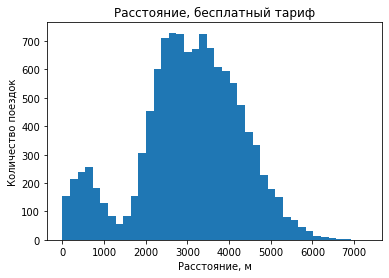

<Figure size 1440x1440 with 0 Axes>

In [38]:
#визуализируем информацию о расстоянии для пользоватлей без подписки
plt.hist(free_sub['distance'], bins=40, range = (0, 7300))
plt.title('Расстояние, бесплатный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

**Медиана расстояния одной поездки пользователей без подписки составляет 3114 метров, среднее 3045 метров**

In [39]:
free_sub['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

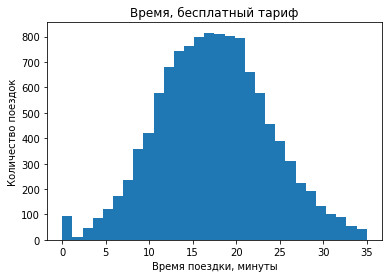

<Figure size 1440x1440 with 0 Axes>

In [40]:
#визуализируем информацию о времени для пользоватлей без подписки
plt.hist(free_sub['duration'], bins=30, range = (0, 35))
plt.title('Время, бесплатный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

**Медиана времени одной поездки пользователей без подписки составляет 17 минут, что совпадает со средним значением**

In [41]:
ultra_sub['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

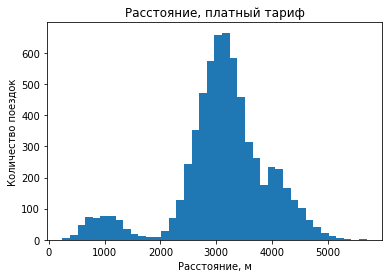

<Figure size 1440x1440 with 0 Axes>

In [42]:
#визуализируем информацию о расстоянии для пользоватлей с подпиской
plt.hist(ultra_sub['distance'], bins=40, range = (240, 5700))
plt.title('Расстояние, платный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

**Медиана расстояния одной поездки пользователей с подпиской составляет 3148 метров, среднее 3115 метров**

In [43]:
ultra_sub['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

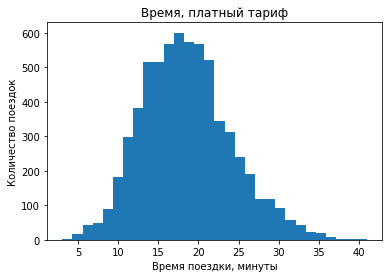

<Figure size 1440x1440 with 0 Axes>

In [44]:
#визуализируем информацию о времени для пользоватлей с подпиской
plt.hist(ultra_sub['duration'], bins=30, range = (3, 41))
plt.title('Время, платный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

**Медиана времени одной поездки пользователей без подписки составляет 18 минут, что совпадает со средним значением**

**Промежуточные выводы**
* в тарифе без подписки пользователи проезжают от 2 до 5 км, время таких поездок составляет от 8 до 25 минут
* в тарифе с подпиской пользователи также проезжают от 2 до 5 км с явным пиком в 3 км, время поездки в интервале от 10 до 25 минут

По графикам распределения можно сделать вывод, что пользователи без подписки проезжают большее расстояние. Время в поездке примерно одинаковое

#### Шаг 5. Подсчёт выручки

In [45]:
#найдем суммарное расстояние, количество поездок и суммарное время
df['duration'] = np.ceil(df['duration'])
data = df.pivot_table(
    index=('user_id', 'month'), 
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee'
    ), 
    aggfunc=({'distance':{'count', 'sum'}, 
             'duration':'sum',
             'minute_price': 'mean',
             'start_ride_price':'mean',
             'subscription_fee':'mean',})
)

data.columns = [
    'count', 'distance', 
    'duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee'
]

data.head()

count     distance  duration  minute_price  start_ride_price  \
user_id month                                                                 
1       1          2  7027.511294      42.0             6                 0   
        4          1   754.159807       7.0             6                 0   
        8          2  6723.470560      46.0             6                 0   
        10         2  5809.911100      32.0             6                 0   
        11         3  7003.499363      56.0             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199

In [46]:
#добавим столбец с помесячной выручкой
data['revenue'] = (
    (data['start_ride_price'] * data['count']) 
    + (data['minute_price'] * data['duration']) 
    + data['subscription_fee']
)
data['revenue'] = data['revenue'].astype('uint16')
#удалим лишние столбцы
data = data.drop(['start_ride_price', 'minute_price'], axis=1)
data.head(10)

count      distance  duration  subscription_fee  revenue
user_id month                                                          
1       1          2   7027.511294      42.0               199      451
        4          1    754.159807       7.0               199      241
        8          2   6723.470560      46.0               199      475
        10         2   5809.911100      32.0               199      391
        11         3   7003.499363      56.0               199      535
        12         2   6751.629942      28.0               199      367
2       3          3  10187.723006      63.0               199      577
        4          2   6164.381824      40.0               199      439
        6          1   3255.338202      14.0               199      283
        7          2   6780.722964      48.0               199      487

#### Шаг 6. Проверка гипотез

**Гипотеза №1:** Проверим, тратят ли пользователи с подпиской больше времени на поездку

H_0: Время пользователей на подписке ultra = время пользователей на подписке free

H_1: Время пользователей на подписке ultra > время пользователей на подписке free

In [47]:
ultra = ultra_sub['duration'] 

free = free_sub['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


**При установленном уровне статистическоц значимости нулевая гипотеза отвергнута, время одной поездки пользователей с подпиской превышает время пользователей без подписки**

**Гипотеза №2:** Проверим, превышает ли расстояние одной поездки пользователей с подпиской 3130 метров

H_0: Расстояние пользователей на подписке ultra = 3130 метров

H_1: Расстояние пользователей на подписке ultra < 3130 метров


In [48]:
ultra_dist = ultra_sub['distance']

interested_value = 3130.0

alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='less')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.08046311521502146
Не удалось отвергнуть нулевую гипотезу


**При установленном уровне статистической значимости не получилось отвергнуть нулевую гипотезу, среднее расстояние одной поездки пользователей с подпиской не превышает оптимальное расстояние в 3130 м**

**Гипотеза №2 (альтернативная):** Проверим, НЕ превышает ли расстояние одной поездки пользователей с подпиской 3130 метров

H_0: Расстояние пользователей на подписке ultra = 3130 метров

H_1: Расстояние пользователей на подписке ultra > 3130 метров


In [49]:
ultra_dist = ultra_sub['distance']

interested_value = 3130.0

alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


**Не получилось отвергнуть нулевую гипотезу, среднее расстояние одной поездки пользователей с подпиской не превышает оптимальное расстояние в 3130 м**

**Гипотеза №3:** Проверим, будет ли помесячная выручка от пользователй с подпиской по месяцам выше, чем выручка от пользователей без подписки

H_0: Выручка пользователей на подписке ultra = выручке пользователей на подписке free

H_1: Выручка пользователей на подписке ultra > выручки пользователей на подписке free

In [50]:
results = st.ttest_ind(
    data.loc[data['subscription_fee'] > 0, 'revenue'], 
    data.loc[data['subscription_fee'] == 0, 'revenue'], 
    equal_var=True, 
    alternative='greater')
print(results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


**При установленном уровне статистической значимости нулевая гипотеза отвергнута, помесячная выручка от пользователй с подпиской по месяцам выше, чем выручка от пользователей без подписки**

**Гипотеза №4 (теоретическая)** 

Нужно использовать гипотезу о равенстве средних для зависимых (парных) выборок.

H0 : μ1 = μ2

H1 : μ1 != μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()

#### Шаг 7. Общий вывод

В ходе исследования проанализировали данные и проверили гипотезы, которые могут помочь бизнесу вырасти.

В ходе анализа было выявлено:
- распределние пользователей по городам примерно одинаковое, в основном преобладают южные регионы
- пользователей без подписки на 8% больше, чем пользователей с подпиской ultra
- сервсисом пользуются люди от 12 до 43 лет, средний возраст пользователя -  25 лет
- в среднем пользователь за одну поездку проезжал 3 км, среднее время в пути - 17 минут

После объединения датафреймов:
* в тарифе без подписки пользователи проезжают от 2 до 5 км, время таких поездок составляет от 8 до 25 минут
* в тарифе с подпиской пользователи также проезжают от 2 до 5 км с явным пиком в 3 км, время поездки в интервале от 10 до 25 минут

По графикам распределения можно сделать вывод, что пользователи без подписки проезжают большее расстояние. Время в поездке примерно одинаковое

По результатам проверки гипотез было определено:
- время одной поездки пользователей с подпиской превышает время пользователей без подписки
- среднее расстояние одной поездки пользователей с подпиской не превышает оптимальное расстояние в 3130 м
- помесячная выручка от пользователй с подпиской по месяцам выше, чем выручка от пользователей без подписки

Рекомендации по развитию сервиса
1. Так как клиенты без подписки в среднем проезжают большее расстояние за одну поездку, чем клиенты с подпиской ultra, то потенциально они могут принести компании хорошую прибыль. Необходимо привлечь данных пользователей, путем рассылки промокода или бесплатного пробного периода на условиях подписки Ultra
2. Оптимизировать расположение самокатов в городе, разместить их в местах большего скопления людей
3. Разработать программу лояльности для действующих клиентов, которые активно пользуются сервисом. Можно разработать реферальную программу, по которой за одного привлеченного клиента месяц подписки в подарок